In [1]:
import numpy as np
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default='notebook'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
import regex as re

In [3]:
df = pd.read_csv('all_data.csv')
df.head()

,Unnamed: 0,text,Label_by_zihan,Label_by_ben,Label_by_nicole,average,label,Qwen 1.5 Chat (0.5B),Qwen 1.5 Chat (1.8B),Qwen 1.5 Chat (4B),Qwen 1.5 Chat (7B),Qwen 1.5 Chat (14B),Qwen 1.5 Chat (72B),LLaMA-2 Chat (70B),GPT-4o,GPT-3.5 Turbo,GPT-4 Turbo,GPT-4o W/O Reasoning,Sentiment Roberta,Custmized Bert
0,0,what do these '1/2 naked pics' have to do with...,3.0,3.0,4.0,3.333333,5,1.0,3.0,1.0,6.0,3.0,3.0,3.0,3.0,3.0,5.0,2.0,3.000812,3.385936
1,1,OH: “I had a blue penis while I was this” [pla...,5.0,5.0,6.0,5.333333,5,7.0,7.0,0.0,0.0,3.0,3.0,6.0,5.0,5.0,6.0,1.0,5.122762,6.015794
2,2,"That's coming, but I think the victims are goi...",5.0,6.0,5.0,5.333333,5,7.0,5.0,2.0,5.0,3.0,4.0,3.0,2.0,2.0,3.0,3.0,4.173433,4.166149
3,3,I think I may be finally in with the in crowd ...,7.0,9.0,7.0,7.666667,10,7.0,7.0,1.0,8.0,6.0,6.0,8.0,8.0,8.0,8.0,8.0,6.907494,7.103713
4,4,"Wow,first Hugo Chavez and now Fidel Castro. Da...",4.0,2.0,3.0,3.000000,0,7.0,7.0,2.0,2.0,3.0,4.0,3.0,3.0,2.0,2.0,2.0,4.960894,3.268210


In [4]:
qwen_all = df.columns[7:13]
data = []
for model in qwen_all:
    params = re.search(r'(\d+(\.\d+)?)([B])', model)
    if params:
        number, _, unit = params.groups()
        number = float(number)
        diffs = (df[model] - df['average']).abs()
        data.append((model, number, diffs.mean()))

In [5]:
model_params = pd.DataFrame(data, columns=['Model', '# Parameters', 'Average Diffs'])
X = model_params['# Parameters'].values.reshape(-1, 1)
y = model_params['Average Diffs'].values

model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)

In [6]:
model_params

,Model,# Parameters,Average Diffs
0,Qwen 1.5 Chat (0.5B),0.5,3.568000
1,Qwen 1.5 Chat (1.8B),1.8,2.688000
2,Qwen 1.5 Chat (4B),4.0,3.160000
3,Qwen 1.5 Chat (7B),7.0,2.006667
4,Qwen 1.5 Chat (14B),14.0,1.280000
5,Qwen 1.5 Chat (72B),72.0,1.058667


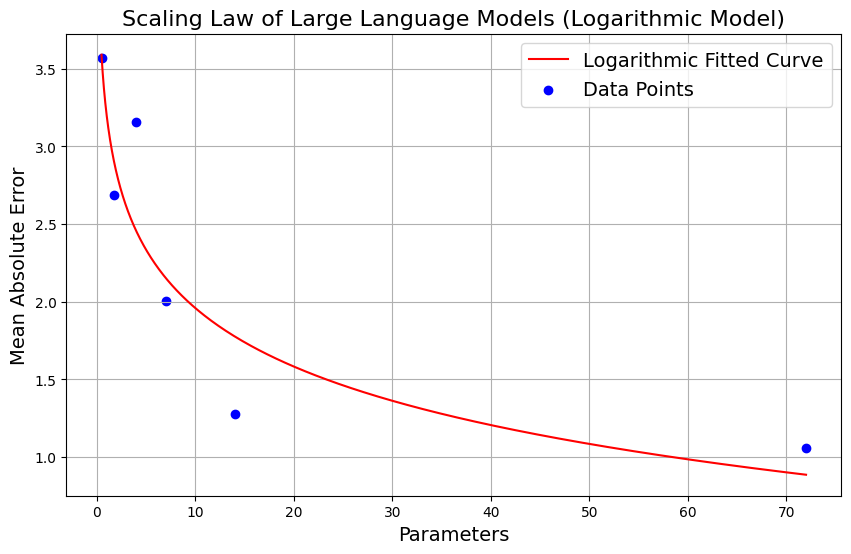

In [28]:
log_parameters = np.log(model_params['# Parameters'])
X_log = sm.add_constant(log_parameters)
model_log = sm.OLS(model_params['Average Diffs'], X_log).fit()
predictions_log = model_log.predict(X_log)

# Generate a smooth curve for the logarithmic regression line
x_smooth_log = np.linspace(log_parameters.min(), log_parameters.max(), 500)
x_smooth_log_exp = np.exp(x_smooth_log)
y_smooth_log = model_log.predict(sm.add_constant(x_smooth_log))

# Plotting the data points and the smooth logarithmic regression line
plt.figure(figsize=(10, 6))
plt.scatter(model_params['# Parameters'], model_params['Average Diffs'], color='blue', label='Data Points')
plt.plot(x_smooth_log_exp, y_smooth_log, color='red', label='Logarithmic Fitted Curve')
plt.xlabel('Parameters', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Scaling Law of Large Language Models (Logarithmic Model)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("logScale.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:          Average Diffs   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     20.80
Date:                Sat, 08 Jun 2024   Prob (F-statistic):             0.0103
Time:                        20:55:38   Log-Likelihood:                -2.5904
No. Observations:                   6   AIC:                             9.181
Df Residuals:                       4   BIC:                             8.764
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.2130      0.275     11.705   

c:\Users\b3nli\anaconda3\envs\ece176\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [9]:
print(model_log.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &  Average Diffs   & \textbf{  R-squared:         } &     0.839   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.798   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     20.80   \\
\textbf{Date:}             & Sat, 08 Jun 2024 & \textbf{  Prob (F-statistic):} &   0.0103    \\
\textbf{Time:}             &     20:55:39     & \textbf{  Log-Likelihood:    } &   -2.5904   \\
\textbf{No. Observations:} &           6      & \textbf{  AIC:               } &     9.181   \\
\textbf{Df Residuals:}     &           4      & \textbf{  BIC:               } &     8.764   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} 

c:\Users\b3nli\anaconda3\envs\ece176\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


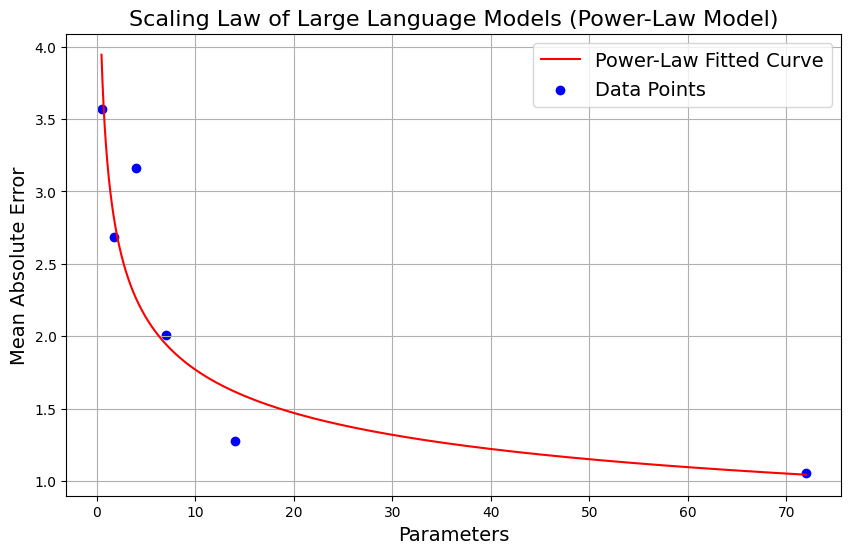

In [27]:
log_parameters_power = np.log(model_params['# Parameters'])
log_average_diffs = np.log(model_params['Average Diffs'])
X_power = sm.add_constant(log_parameters_power)
model_power = sm.OLS(log_average_diffs, X_power).fit()
predictions_power = np.exp(model_power.predict(X_power))

# Generate a smooth curve for the power-law regression line
x_smooth_log_power = np.linspace(log_parameters_power.min(), log_parameters_power.max(), 500)
x_smooth_power = np.exp(x_smooth_log_power)
y_smooth_power = np.exp(model_power.predict(sm.add_constant(x_smooth_log_power)))

# Plotting the data points and the smooth power-law regression line
plt.figure(figsize=(10, 6))
plt.scatter(model_params['# Parameters'], model_params['Average Diffs'], color='blue', label='Data Points')
plt.plot(x_smooth_power, y_smooth_power, color='red', label='Power-Law Fitted Curve')
plt.xlabel('Parameters', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Scaling Law of Large Language Models (Power-Law Model)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("powerLaw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [14]:
print(model_power.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &  Average Diffs   & \textbf{  R-squared:         } &     0.853   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.817   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     23.29   \\
\textbf{Date:}             & Sat, 08 Jun 2024 & \textbf{  Prob (F-statistic):} &  0.00848    \\
\textbf{Time:}             &     22:09:58     & \textbf{  Log-Likelihood:    } &    2.0139   \\
\textbf{No. Observations:} &           6      & \textbf{  AIC:               } &  -0.02783   \\
\textbf{Df Residuals:}     &           4      & \textbf{  BIC:               } &   -0.4443   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} 

c:\Users\b3nli\anaconda3\envs\ece176\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
